# Homework 13 - Network Compression

Author: Liang-Hsuan Tseng (b07502072@ntu.edu.tw), modified from ML2021-HW13

If you have any questions, feel free to ask: ntu-ml-2022spring-ta@googlegroups.com

[**Link to HW13 Slides**](https://docs.google.com/presentation/d/1nCT9XrInF21B4qQAWuODy5sonKDnpGhjtcAwqa75mVU/edit#slide=id.p)

## Outline

* [Packages](#Packages) - intall some required packages.
* [Dataset](#Dataset) - something you need to know about the dataset.
* [Configs](#Configs) - the configs of the experiments, you can change some hyperparameters here.
* [Architecture_Design](#Architecture_Design) - depthwise and pointwise convolution examples and some useful links.
* [Knowledge_Distillation](#Knowledge_Distillation) - KL divergence loss for knowledge distillation and some useful links.
* [Training](#Training) - training loop implementation modified from HW3.
* [Inference](#Inference) - create submission.csv by using the student_best.ckpt from the previous experiment.



### Dataset
We use Food11 dataset for this homework, which is similar to homework3. But remember, Please DO NOT utilize the dataset of HW3. We've modified the dataset, so you should only access the dataset by loading it in this kaggle notebook or through the links provided in the HW13 colab notebooks.

In [ ]:
# fetch and download the dataset from github (about 1.12G)
# !wget https://github.com/virginiakm1988/ML2022-Spring/raw/main/HW13/food11-hw13.tar.gz 
## backup links:

!wget https://github.com/andybi7676/ml2022spring-hw13/raw/main/food11-hw13.tar.gz -O food11-hw13.tar.gz
# !gdown '1ijKoNmpike_yjUw8SWRVVWVoMOXXqycj' --output food11-hw13.tar.gz

--2022-06-15 02:22:38--  https://github.com/andybi7676/ml2022spring-hw13/raw/main/food11-hw13.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/andybi7676/ml2022spring-hw13/main/food11-hw13.tar.gz [following]
--2022-06-15 02:22:38--  https://media.githubusercontent.com/media/andybi7676/ml2022spring-hw13/main/food11-hw13.tar.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1203320552 (1.1G) [application/octet-stream]
Saving to: ‘food11-hw13.tar.gz’

food11-hw13.tar.gz  100%[===================>]   1.12G   244MB/s    in 4.6s    

2022-06-15 02:22:43 (249 MB/s) - ‘food11-hw13

In [ ]:
# extract the data
!tar -xzf ./food11-hw13.tar.gz # Could take some time
# !tar -xzvf ./food11-hw13.tar.gz # use this command if you want to checkout the whole process.

In [ ]:
import os
for dirname, _, filenames in os.walk('./food11-hw13'):
    if len(filenames) > 0:
        print(f"{dirname}: {len(filenames)} files.") # Show the file amounts in each split.

./food11-hw13: 1 files.
./food11-hw13/evaluation: 3347 files.
./food11-hw13/training: 9866 files.
./food11-hw13/validation: 3430 files.


### Packages
First, we need to import some useful packages. If the torchsummary package are not intalled, please install it via `pip install torchsummary`

In [ ]:
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
# import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random

!nvidia-smi # list your current GPU

Wed Jun 15 02:23:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Configs
In this part, you can specify some variables and hyperparameters as your configs.

In [ ]:
cfg = {
    'dataset_root': './food11-hw13',
    'save_dir': './outputs',
    'exp_name': "simple_baseline",
    'batch_size': 128,
    'lr': 1e-3,
    'seed': 20220013,
    'loss_fn_type': 'KD', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 1e-5,
    'grad_norm_max': 10,
    'n_epochs': 150, # train more steps to pass the medium baseline.
    'patience': 300,
}

In [ ]:
myseed = cfg['seed']  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
random.seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    print(text)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)  # log your configs to the log file

{'dataset_root': './food11-hw13', 'save_dir': './outputs', 'exp_name': 'simple_baseline', 'batch_size': 128, 'lr': 0.001, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 1e-05, 'grad_norm_max': 10, 'n_epochs': 150, 'patience': 300}


Next, specify train/test transform for image data augmentation.
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms. You can also apply the knowledge or experience you learned in HW3.

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    transforms.Resize(256),  # You can change this
    transforms.RandomRotation(15),
    # transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    transforms.RandomCrop(244),
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    transforms.RandomHorizontalFlip(), # You can change this.
    transforms.ColorJitter(brightness=0.9, contrast=0.9, saturation=0.0, hue=0),
    transforms.ToTensor(),
    normalize,
])

In [ ]:
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

In [ ]:
# Form train/valid dataloaders
train_set = FoodDataset(os.path.join(cfg['dataset_root'],"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

One ./food11-hw13/training sample ./food11-hw13/training/0_0.jpg
One ./food11-hw13/validation sample ./food11-hw13/validation/0_0.jpg


### Architecture_Design

In this homework, you have to design a smaller network and make it perform well. Apparently, a well-designed architecture is crucial for such task. Here, we introduce the depthwise and pointwise convolution. These variants of convolution are some common techniques for architecture design when it comes to network compression.

<img src="https://i.imgur.com/LFDKHOp.png" width=400px>

* explanation of depthwise and pointwise convolutions:
    * [prof. Hung-yi Lee's slides(p.24~p.30, especially p.28)](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/tiny_v7.pdf)

In [ ]:
# Example implementation of Depthwise and Pointwise Convolution 
def dwpw_conv(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels), #depthwise convolution
        nn.BatchNorm2d(in_channels),
        nn.ReLU6(),
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
        nn.MaxPool2d(2)
    )

* other useful techniques
    * [group convolution](https://www.researchgate.net/figure/The-transformations-within-a-layer-in-DenseNets-left-and-CondenseNets-at-training-time_fig2_321325862) (Actually, depthwise convolution is a specific type of group convolution)
    * [SqueezeNet](!https://arxiv.org/abs/1602.07360)
    * [MobileNet](!https://arxiv.org/abs/1704.04861)
    * [ShuffleNet](!https://arxiv.org/abs/1707.01083)
    * [Xception](!https://arxiv.org/abs/1610.02357)
    * [GhostNet](!https://arxiv.org/abs/1911.11907)


After introducing depthwise and pointwise convolutions, let's define the **student network architecture**. Here, we have a very simple network formed by some regular convolution layers and pooling layers. You can replace the regular convolution layers with the depthwise and pointwise convolutions. In this way, you can further increase the depth or the width of your network architecture.

In [ ]:
# # Define your student network here. You have to copy-paste this code block to HW13 GradeScope before deadline.
# # We will use your student network definition to evaluate your results(including the total parameter amount).

# class StudentNet(nn.Module):
#     def __init__(self):
#       super().__init__()

#       # ---------- TODO ----------
#       # Modify your model architecture

#       self.cnn = nn.Sequential(
#         nn.Conv2d(3, 32, 3), 
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Conv2d(32, 32, 3),  
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2, 0),     

#         nn.Conv2d(32, 64, 3), 
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2, 0),     

#         nn.Conv2d(64, 100, 3), 
#         nn.BatchNorm2d(100),
#         nn.ReLU(),
#         nn.MaxPool2d(2, 2, 0),
        
#         # Here we adopt Global Average Pooling for various input size.
#         nn.AdaptiveAvgPool2d((1, 1)),
#       )
#       self.fc = nn.Sequential(
#         nn.Linear(100, 11),
#       )
      
#     def forward(self, x):
#       out = self.cnn(x)
#       out = out.view(out.size()[0], -1)
#       return self.fc(out)

# def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
#     # you can modify or do anything here, just remember to return an nn.Module as your student network.  
#     return StudentNet() 

# # End of definition of your student model and the get_student_model API
# # Please copy-paste the whole code block, including the get_student_model function.

In [ ]:
class StudentNet(nn.Module):
    def __init__(self):
      super(StudentNet, self).__init__()

      # ---------- TODO ----------
      # Modify your model architecture

      self.cnn =  nn.Sequential(
            nn.Sequential(
                nn.Conv2d(3, 32, 3, 1, 0),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2),
            ),

            dwpw_conv(32, 64, 3, 1, 0),
            dwpw_conv(64, 128, 3, 1, 0),
            dwpw_conv(128, 256, 3, 1, 0),

            nn.Sequential(
                nn.Conv2d(256, 256, 3, 1, 0, groups=256),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 150, 1),
            ),

            # Here we adopt Global Average Pooling for various input size.
            nn.AdaptiveAvgPool2d((1, 1)),
      )
      self.fc = nn.Sequential(
        nn.Linear(150, 11),
      )
      
    def forward(self, x):
      out = self.cnn(x)
      out = out.view(out.size()[0], -1)
      return self.fc(out)

def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
    # you can modify or do anything here, just remember to return an nn.Module as your student network.  
    return StudentNet() 

https://github.com/jmjeon94/MobileNet-Pytorch/blob/master/MobileNetV1.py

After specifying the student network architecture, please use `torchsummary` package to get information about the network and verify the total number of parameters. Note that the total params of your student network should not exceed the limit (`Total params` in `torchsummary` ≤ 100,000). 

In [ ]:
# DO NOT modify this block and please make sure that this block can run sucessfully. 
student_model = get_student_model()
summary(student_model, (3, 224, 224), device='cpu')
# You have to copy&paste the results of this block to HW13 GradeScope. 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
       BatchNorm2d-2         [-1, 32, 222, 222]              64
              ReLU-3         [-1, 32, 222, 222]               0
         MaxPool2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]             320
       BatchNorm2d-6         [-1, 32, 109, 109]              64
             ReLU6-7         [-1, 32, 109, 109]               0
            Conv2d-8         [-1, 64, 109, 109]           2,112
         MaxPool2d-9           [-1, 64, 54, 54]               0
           Conv2d-10           [-1, 64, 52, 52]             640
      BatchNorm2d-11           [-1, 64, 52, 52]             128
            ReLU6-12           [-1, 64, 52, 52]               0
           Conv2d-13          [-1, 128, 52, 52]           8,320
        MaxPool2d-14          [-1, 128,

In [ ]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))
# Now you already know the teacher model's architecture. You can take advantage of it if you want to pass the strong or boss baseline. 
# Source code of resnet in pytorch: (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
# You can also see the summary of teacher model. There are 11,182,155 parameters totally in the teacher model
# summary(teacher_model, (3, 224, 224), device='cpu')

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


<All keys matched successfully>

### Knowledge_Distillation

<img src="https://i.imgur.com/H2aF7Rv.png=100x" width="400px">

Since we have a learned big model, let it teach the other small model. In implementation, let the training target be the prediction of big model instead of the ground truth.

**Why it works?**
* If the data is not clean, then the prediction of big model could ignore the noise of the data with wrong labeled.
* There might have some relations between classes, so soft labels from teacher model might be useful. For example, Number 8 is more similar to 6, 9, 0 than 1, 7.


**How to implement?**
* $Loss = \alpha T^2 \times KL(p || q) + (1-\alpha)(\text{Original Cross Entropy Loss}), \text{where } p=softmax(\frac{\text{student's logits}}{T}), \text{and } q=softmax(\frac{\text{teacher's logits}}{T})$
* very useful link: [pytorch docs of KLDivLoss with examples](!https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
* original paper: [Distilling the Knowledge in a Neural Network](!https://arxiv.org/abs/1503.02531)

In [ ]:
# Implement the loss function with KL divergence loss for knowledge distillation.
# You also have to copy-paste this whole block to HW13 GradeScope. 
def loss_fn_kd(student_logits, labels, teacher_logits, alpha=0.5, temperature=20.0):
    # ------------TODO-------------
    # Refer to the above formula and finish the loss function for knowkedge distillation using KL divergence loss and CE loss.
    # If you have no idea, please take a look at the provided useful link above.
    hard_loss = F.cross_entropy(student_logits, labels) * (1. - alpha)
    p = F.log_softmax(student_logits / temperature , dim=1)
    q = F.softmax(teacher_logits / temperature, dim=1)
    soft_loss = F.kl_div(p, q, reduction='batchmean') * alpha * (temperature ** 2)
    return hard_loss + soft_loss

In [ ]:
# choose the loss function by the config
if cfg['loss_fn_type'] == 'CE':
    # For the classification task, we use cross-entropy as the default loss function.
    loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.

if cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
    loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.

# You can also adopt other types of knowledge distillation techniques for strong and boss baseline, but use function name other than `loss_fn_kd`
# For example:
# def loss_fn_custom_kd():
#     pass
# if cfg['loss_fn_type'] == 'custom_kd':
#     loss_fn = loss_fn_custom_kd

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
log(f"device: {device}")

# The number of training epochs and patience.
n_epochs = cfg['n_epochs']
patience = cfg['patience'] # If no improvement in 'patience' epochs, early stop

device: cuda


### Training
implement training loop for simple baseline, feel free to modify it.

In [ ]:
# Initialize a model, and put it on the device specified.
student_model.to(device)
teacher_model.to(device) # MEDIUM BASELINE

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 70, 90, 110, 130], gamma=0.4)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.0

teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        logits = student_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
        # loss = loss_fn(logits, labels) # SIMPLE BASELINE
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append(loss.item() * train_batch_len)
        train_accs.append(acc)
        train_lens.append(train_batch_len)
        
    train_loss = sum(train_loss) / sum(train_lens)
    train_acc = sum(train_accs) / sum(train_lens)

    # Update lr
    scheduler.step()

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}, lr = {scheduler.get_last_lr()[0]:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    student_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    if epoch > 50:
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = student_model(imgs)
                teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

            # We can still compute the loss (but not the gradient).
            loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
            # loss = loss_fn(logits, labels) # SIMPLE BASELINE

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels).float().sum()

            # Record the loss and accuracy.
            batch_len = len(imgs)
            valid_loss.append(loss.item() * batch_len)
            valid_accs.append(acc)
            valid_lens.append(batch_len)
            #break

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / sum(valid_lens)
        valid_acc = sum(valid_accs) / sum(valid_lens)
    else:
        valid_loss = 1000.0
        valid_acc = 0.0


    # update logs
    
    if valid_acc > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        log(f"Best model found at epoch {epoch}, saving model")
        torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()

  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 001/150 ] loss = 7.59386, acc = 0.24285, lr = 0.00100
[ Valid | 001/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 002/150 ] loss = 7.10404, acc = 0.30975, lr = 0.00100
[ Valid | 002/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 003/150 ] loss = 6.62564, acc = 0.35050, lr = 0.00100
[ Valid | 003/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 004/150 ] loss = 6.38996, acc = 0.37857, lr = 0.00100
[ Valid | 004/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 005/150 ] loss = 6.20763, acc = 0.40635, lr = 0.00100
[ Valid | 005/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 006/150 ] loss = 5.91565, acc = 0.43300, lr = 0.00100
[ Valid | 006/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 007/150 ] loss = 5.78825, acc = 0.44314, lr = 0.00100
[ Valid | 007/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 008/150 ] loss = 5.64452, acc = 0.47040, lr = 0.00100
[ Valid | 008/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 009/150 ] loss = 5.39010, acc = 0.48814, lr = 0.00100
[ Valid | 009/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 010/150 ] loss = 5.33885, acc = 0.49838, lr = 0.00100
[ Valid | 010/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 011/150 ] loss = 5.17287, acc = 0.51966, lr = 0.00100
[ Valid | 011/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 012/150 ] loss = 5.14461, acc = 0.51987, lr = 0.00100
[ Valid | 012/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 013/150 ] loss = 4.98815, acc = 0.53132, lr = 0.00100
[ Valid | 013/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 014/150 ] loss = 4.95288, acc = 0.53771, lr = 0.00100
[ Valid | 014/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 015/150 ] loss = 4.83650, acc = 0.54855, lr = 0.00100
[ Valid | 015/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 016/150 ] loss = 4.74457, acc = 0.55777, lr = 0.00100
[ Valid | 016/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 017/150 ] loss = 4.69508, acc = 0.56710, lr = 0.00100
[ Valid | 017/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 018/150 ] loss = 4.58020, acc = 0.56913, lr = 0.00100
[ Valid | 018/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 019/150 ] loss = 4.53781, acc = 0.58109, lr = 0.00100
[ Valid | 019/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 020/150 ] loss = 4.48891, acc = 0.58920, lr = 0.00100
[ Valid | 020/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 021/150 ] loss = 4.43804, acc = 0.59416, lr = 0.00100
[ Valid | 021/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 022/150 ] loss = 4.36623, acc = 0.59528, lr = 0.00100
[ Valid | 022/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 023/150 ] loss = 4.27895, acc = 0.60663, lr = 0.00100
[ Valid | 023/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 024/150 ] loss = 4.27053, acc = 0.60511, lr = 0.00100
[ Valid | 024/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 025/150 ] loss = 4.19850, acc = 0.61443, lr = 0.00100
[ Valid | 025/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 026/150 ] loss = 4.16117, acc = 0.62254, lr = 0.00100
[ Valid | 026/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 027/150 ] loss = 4.08129, acc = 0.62133, lr = 0.00100
[ Valid | 027/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 028/150 ] loss = 4.06666, acc = 0.62579, lr = 0.00100
[ Valid | 028/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 029/150 ] loss = 3.97321, acc = 0.63075, lr = 0.00100
[ Valid | 029/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 030/150 ] loss = 3.96296, acc = 0.63258, lr = 0.00100
[ Valid | 030/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 031/150 ] loss = 3.92646, acc = 0.62437, lr = 0.00100
[ Valid | 031/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 032/150 ] loss = 3.88977, acc = 0.63825, lr = 0.00100
[ Valid | 032/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 033/150 ] loss = 3.88102, acc = 0.64717, lr = 0.00100
[ Valid | 033/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 034/150 ] loss = 3.86955, acc = 0.64008, lr = 0.00100
[ Valid | 034/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 035/150 ] loss = 3.75456, acc = 0.64849, lr = 0.00100
[ Valid | 035/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 036/150 ] loss = 3.78885, acc = 0.64322, lr = 0.00100
[ Valid | 036/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 037/150 ] loss = 3.77058, acc = 0.65194, lr = 0.00100
[ Valid | 037/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 038/150 ] loss = 3.73827, acc = 0.65386, lr = 0.00100
[ Valid | 038/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 039/150 ] loss = 3.69846, acc = 0.66400, lr = 0.00100
[ Valid | 039/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 040/150 ] loss = 3.62525, acc = 0.66481, lr = 0.00100
[ Valid | 040/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 041/150 ] loss = 3.62744, acc = 0.66359, lr = 0.00100
[ Valid | 041/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 042/150 ] loss = 3.59786, acc = 0.66055, lr = 0.00100
[ Valid | 042/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 043/150 ] loss = 3.61662, acc = 0.66420, lr = 0.00100
[ Valid | 043/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 044/150 ] loss = 3.55781, acc = 0.66886, lr = 0.00100
[ Valid | 044/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 045/150 ] loss = 3.56850, acc = 0.66846, lr = 0.00100
[ Valid | 045/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 046/150 ] loss = 3.56233, acc = 0.66927, lr = 0.00100
[ Valid | 046/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 047/150 ] loss = 3.48959, acc = 0.68255, lr = 0.00100
[ Valid | 047/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 048/150 ] loss = 3.45047, acc = 0.68123, lr = 0.00100
[ Valid | 048/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 049/150 ] loss = 3.49455, acc = 0.67636, lr = 0.00100
[ Valid | 049/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 050/150 ] loss = 3.44599, acc = 0.68366, lr = 0.00040
[ Valid | 050/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 051/150 ] loss = 3.28129, acc = 0.69897, lr = 0.00040
[ Valid | 051/150 ] loss = 1000.00000, acc = 0.00000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 052/150 ] loss = 3.28715, acc = 0.69816, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 052/150 ] loss = 6.48788, acc = 0.71050 -> best
Best model found at epoch 51, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 053/150 ] loss = 3.27487, acc = 0.70180, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 053/150 ] loss = 6.48299, acc = 0.72945 -> best
Best model found at epoch 52, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 054/150 ] loss = 3.20407, acc = 0.71022, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 054/150 ] loss = 6.58423, acc = 0.72245


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 055/150 ] loss = 3.22938, acc = 0.70484, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 055/150 ] loss = 6.38837, acc = 0.71778


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 056/150 ] loss = 3.22962, acc = 0.70849, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 056/150 ] loss = 6.40849, acc = 0.71778


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 057/150 ] loss = 3.18907, acc = 0.70930, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 057/150 ] loss = 6.52239, acc = 0.71720


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 058/150 ] loss = 3.22253, acc = 0.70262, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 058/150 ] loss = 6.46097, acc = 0.70233


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 059/150 ] loss = 3.17344, acc = 0.70971, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 059/150 ] loss = 6.27982, acc = 0.72420


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 060/150 ] loss = 3.16865, acc = 0.71184, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 060/150 ] loss = 6.46069, acc = 0.72595


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 061/150 ] loss = 3.17305, acc = 0.71741, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 061/150 ] loss = 6.36306, acc = 0.71662


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 062/150 ] loss = 3.13165, acc = 0.71478, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 062/150 ] loss = 6.43193, acc = 0.70816


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 063/150 ] loss = 3.15541, acc = 0.71458, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 063/150 ] loss = 6.41460, acc = 0.72012


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 064/150 ] loss = 3.17398, acc = 0.71072, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 064/150 ] loss = 6.30656, acc = 0.72974 -> best
Best model found at epoch 63, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 065/150 ] loss = 3.13835, acc = 0.72238, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 065/150 ] loss = 6.46771, acc = 0.70554


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 066/150 ] loss = 3.13575, acc = 0.72005, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 066/150 ] loss = 6.30488, acc = 0.72391


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 067/150 ] loss = 3.13056, acc = 0.71346, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 067/150 ] loss = 6.37524, acc = 0.73149 -> best
Best model found at epoch 66, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 068/150 ] loss = 3.13332, acc = 0.71812, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 068/150 ] loss = 6.36000, acc = 0.72653


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 069/150 ] loss = 3.10803, acc = 0.72187, lr = 0.00040


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 069/150 ] loss = 6.16619, acc = 0.72682


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 070/150 ] loss = 3.07597, acc = 0.71833, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 070/150 ] loss = 6.39366, acc = 0.70321


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 071/150 ] loss = 3.03405, acc = 0.72826, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 071/150 ] loss = 6.10486, acc = 0.73848 -> best
Best model found at epoch 70, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 072/150 ] loss = 3.00027, acc = 0.73079, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 072/150 ] loss = 6.15056, acc = 0.73732


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 073/150 ] loss = 3.00956, acc = 0.72633, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 073/150 ] loss = 6.10462, acc = 0.73994 -> best
Best model found at epoch 72, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 074/150 ] loss = 2.97578, acc = 0.72694, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 074/150 ] loss = 6.16210, acc = 0.72420


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 075/150 ] loss = 3.00090, acc = 0.73181, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 075/150 ] loss = 6.16772, acc = 0.72741


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 076/150 ] loss = 3.00250, acc = 0.73606, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 076/150 ] loss = 6.08838, acc = 0.74257 -> best
Best model found at epoch 75, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 077/150 ] loss = 3.01533, acc = 0.73393, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 077/150 ] loss = 6.03921, acc = 0.73469


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 078/150 ] loss = 3.00749, acc = 0.72877, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 078/150 ] loss = 6.06313, acc = 0.73790


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 079/150 ] loss = 2.98594, acc = 0.73272, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 079/150 ] loss = 6.00665, acc = 0.73732


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 080/150 ] loss = 2.98272, acc = 0.73231, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 080/150 ] loss = 6.07911, acc = 0.72449


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 081/150 ] loss = 2.98259, acc = 0.73566, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 081/150 ] loss = 6.00511, acc = 0.73469


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 082/150 ] loss = 3.00410, acc = 0.73373, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 082/150 ] loss = 6.12258, acc = 0.73324


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 083/150 ] loss = 2.99334, acc = 0.73150, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 083/150 ] loss = 6.06863, acc = 0.72653


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 084/150 ] loss = 2.95728, acc = 0.73860, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 084/150 ] loss = 6.05036, acc = 0.73732


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 085/150 ] loss = 2.95485, acc = 0.73576, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 085/150 ] loss = 5.99683, acc = 0.73790


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 086/150 ] loss = 2.98201, acc = 0.73525, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 086/150 ] loss = 6.06321, acc = 0.72945


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 087/150 ] loss = 2.97406, acc = 0.73728, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 087/150 ] loss = 5.99638, acc = 0.73353


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 088/150 ] loss = 2.96275, acc = 0.73282, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 088/150 ] loss = 6.07139, acc = 0.72595


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 089/150 ] loss = 2.95244, acc = 0.73262, lr = 0.00016


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 089/150 ] loss = 6.08893, acc = 0.73965


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 090/150 ] loss = 2.88996, acc = 0.73921, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 090/150 ] loss = 6.02132, acc = 0.73090


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 091/150 ] loss = 2.94512, acc = 0.73910, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 091/150 ] loss = 5.94957, acc = 0.74052


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 092/150 ] loss = 2.92143, acc = 0.73383, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 092/150 ] loss = 5.96709, acc = 0.73499


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 093/150 ] loss = 2.89462, acc = 0.74336, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 093/150 ] loss = 5.95207, acc = 0.73149


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 094/150 ] loss = 2.95471, acc = 0.73333, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 094/150 ] loss = 5.98261, acc = 0.74286 -> best
Best model found at epoch 93, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 095/150 ] loss = 2.86304, acc = 0.74265, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 095/150 ] loss = 5.99814, acc = 0.73732


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 096/150 ] loss = 2.90684, acc = 0.74103, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 096/150 ] loss = 5.99008, acc = 0.73790


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 097/150 ] loss = 2.90479, acc = 0.73961, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 097/150 ] loss = 5.93664, acc = 0.73411


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 098/150 ] loss = 2.95609, acc = 0.73860, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 098/150 ] loss = 5.96058, acc = 0.73557


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 099/150 ] loss = 2.90385, acc = 0.73779, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 099/150 ] loss = 5.88455, acc = 0.73615


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 100/150 ] loss = 2.92614, acc = 0.74579, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 100/150 ] loss = 5.97962, acc = 0.73819


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 101/150 ] loss = 2.91352, acc = 0.73981, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 101/150 ] loss = 5.91119, acc = 0.74286


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 102/150 ] loss = 2.88432, acc = 0.74225, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 102/150 ] loss = 5.94026, acc = 0.73790


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 103/150 ] loss = 2.90802, acc = 0.74144, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 103/150 ] loss = 5.98785, acc = 0.73557


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 104/150 ] loss = 2.92270, acc = 0.74002, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 104/150 ] loss = 5.91299, acc = 0.73761


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 105/150 ] loss = 2.89219, acc = 0.74326, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 105/150 ] loss = 5.97281, acc = 0.73761


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 106/150 ] loss = 2.91600, acc = 0.73931, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 106/150 ] loss = 5.90786, acc = 0.73528


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 107/150 ] loss = 2.94213, acc = 0.74245, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 107/150 ] loss = 5.95461, acc = 0.72915


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 108/150 ] loss = 2.90626, acc = 0.74154, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 108/150 ] loss = 5.94640, acc = 0.74286


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 109/150 ] loss = 2.92368, acc = 0.74407, lr = 0.00006


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 109/150 ] loss = 5.91188, acc = 0.74111


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 110/150 ] loss = 2.90239, acc = 0.74397, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 110/150 ] loss = 5.89076, acc = 0.73411


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 111/150 ] loss = 2.88470, acc = 0.74863, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 111/150 ] loss = 5.90711, acc = 0.73673


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 112/150 ] loss = 2.92002, acc = 0.74245, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 112/150 ] loss = 5.90372, acc = 0.74169


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 113/150 ] loss = 2.90564, acc = 0.74468, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 113/150 ] loss = 5.89844, acc = 0.73878


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 114/150 ] loss = 2.88090, acc = 0.73748, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 114/150 ] loss = 5.94199, acc = 0.73848


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 115/150 ] loss = 2.87521, acc = 0.74995, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 115/150 ] loss = 5.89722, acc = 0.74052


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 116/150 ] loss = 2.90995, acc = 0.74397, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 116/150 ] loss = 5.91793, acc = 0.73994


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 117/150 ] loss = 2.87802, acc = 0.75157, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 117/150 ] loss = 5.90195, acc = 0.73878


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 118/150 ] loss = 2.88723, acc = 0.74671, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 118/150 ] loss = 5.91191, acc = 0.74169


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 119/150 ] loss = 2.86338, acc = 0.74498, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 119/150 ] loss = 5.86816, acc = 0.73819


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 120/150 ] loss = 2.88048, acc = 0.74275, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 120/150 ] loss = 5.92804, acc = 0.74490 -> best
Best model found at epoch 119, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 121/150 ] loss = 2.89220, acc = 0.74721, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 121/150 ] loss = 5.87376, acc = 0.73936


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 122/150 ] loss = 2.92979, acc = 0.74306, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 122/150 ] loss = 5.86830, acc = 0.73353


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 123/150 ] loss = 2.89587, acc = 0.74630, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 123/150 ] loss = 5.87971, acc = 0.74023


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 124/150 ] loss = 2.85489, acc = 0.74488, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 124/150 ] loss = 5.88239, acc = 0.74111


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 125/150 ] loss = 2.84230, acc = 0.74681, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 125/150 ] loss = 5.95683, acc = 0.74227


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 126/150 ] loss = 2.88814, acc = 0.74012, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 126/150 ] loss = 5.87381, acc = 0.73878


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 127/150 ] loss = 2.88796, acc = 0.74326, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 127/150 ] loss = 5.90482, acc = 0.73761


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 128/150 ] loss = 2.90057, acc = 0.74721, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 128/150 ] loss = 5.88640, acc = 0.73557


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 129/150 ] loss = 2.85030, acc = 0.74792, lr = 0.00003


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 129/150 ] loss = 5.89555, acc = 0.73615


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 130/150 ] loss = 2.84367, acc = 0.74610, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 130/150 ] loss = 5.87409, acc = 0.73965


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 131/150 ] loss = 2.88625, acc = 0.74863, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 131/150 ] loss = 5.93953, acc = 0.73499


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 132/150 ] loss = 2.88101, acc = 0.74255, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 132/150 ] loss = 5.87242, acc = 0.73644


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 133/150 ] loss = 2.87773, acc = 0.74711, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 133/150 ] loss = 5.88996, acc = 0.74373


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 134/150 ] loss = 2.85875, acc = 0.74873, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 134/150 ] loss = 5.93202, acc = 0.73907


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 135/150 ] loss = 2.86431, acc = 0.74843, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 135/150 ] loss = 5.86121, acc = 0.74257


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 136/150 ] loss = 2.86441, acc = 0.74731, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 136/150 ] loss = 5.88657, acc = 0.73848


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 137/150 ] loss = 2.84471, acc = 0.74782, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 137/150 ] loss = 5.91363, acc = 0.73790


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 138/150 ] loss = 2.86135, acc = 0.74823, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 138/150 ] loss = 5.90789, acc = 0.74082


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 139/150 ] loss = 2.86888, acc = 0.74843, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 139/150 ] loss = 5.88029, acc = 0.73936


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 140/150 ] loss = 2.87085, acc = 0.74985, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 140/150 ] loss = 5.86598, acc = 0.73907


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 141/150 ] loss = 2.84244, acc = 0.75056, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 141/150 ] loss = 5.86004, acc = 0.74286


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 142/150 ] loss = 2.87271, acc = 0.74975, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 142/150 ] loss = 5.89452, acc = 0.74548 -> best
Best model found at epoch 141, saving model


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 143/150 ] loss = 2.80978, acc = 0.75177, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 143/150 ] loss = 5.86352, acc = 0.74227


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 144/150 ] loss = 2.87450, acc = 0.75117, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 144/150 ] loss = 5.89189, acc = 0.74461


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 145/150 ] loss = 2.85427, acc = 0.74377, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 145/150 ] loss = 5.87447, acc = 0.73965


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 146/150 ] loss = 2.87771, acc = 0.74924, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 146/150 ] loss = 5.86194, acc = 0.74344


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 147/150 ] loss = 2.85536, acc = 0.74711, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 147/150 ] loss = 5.86863, acc = 0.73936


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 148/150 ] loss = 2.88859, acc = 0.74772, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 148/150 ] loss = 5.87324, acc = 0.73936


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 149/150 ] loss = 2.88520, acc = 0.74549, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 149/150 ] loss = 5.86334, acc = 0.74023


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 150/150 ] loss = 2.85555, acc = 0.74883, lr = 0.00001


  0%|          | 0/27 [00:00<?, ?it/s]

[ Valid | 150/150 ] loss = 5.87746, acc = 0.73848
Finish training


### Inference
load the best model of the experiment and generate submission.csv

In [ ]:
# create dataloader for evaluation
eval_set = FoodDataset(os.path.join(cfg['dataset_root'], "evaluation"), tfm=test_tfm)
eval_loader = DataLoader(eval_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

One ./food11-hw13/evaluation sample ./food11-hw13/evaluation/0000.jpg


In [ ]:
# Load model from {exp_name}/student_best.ckpt
student_model_best = get_student_model() # get a new student model to avoid reference before assignment.
ckpt_path = f"{save_path}/student_best.ckpt" # the ckpt path of the best student model.
student_model_best.load_state_dict(torch.load(ckpt_path, map_location='cpu')) # load the state dict and set it to the student model
student_model_best.to(device) # set the student model to device

# Start evaluate
student_model_best.eval()
eval_preds = [] # storing predictions of the evaluation dataset

# Iterate the validation set by batches.
for batch in tqdm(eval_loader):
    # A batch consists of image data and corresponding labels.
    imgs, _ = batch
    # We don't need gradient in evaluation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = student_model_best(imgs.to(device))
        preds = list(logits.argmax(dim=-1).squeeze().cpu().numpy())
    # loss and acc can not be calculated because we do not have the true labels of the evaluation set.
    eval_preds += preds

def pad4(i):
    return "0"*(4-len(str(i))) + str(i)

# Save prediction results
ids = [pad4(i) for i in range(0,len(eval_set))]
categories = eval_preds

df = pd.DataFrame()
df['Id'] = ids
df['Category'] = categories
df.to_csv(f"{save_path}/submission.csv", index=False) # now you can download the submission.csv and upload it to the kaggle competition.

  0%|          | 0/27 [00:00<?, ?it/s]

> Don't forget to answer the report questions on GradeScope! 

### Report
* [No relation Haha XD](https://colab.research.google.com/github/soniajoseph/Pruning/blob/master/Pruning_PyTorch.ipynb)
* [Sample](https://stackoverflow.com/questions/69311857/why-doesnt-torch-pruning-actually-remove-filters-or-weights)

In [ ]:
import torch.nn.utils.prune as prune
import copy

In [ ]:
def prune_model_l1_unstructured(model, layer_type, ratio=0.9): 
  prun_model = copy.deepcopy(model)
  for name, module in prun_model.named_modules():
      if isinstance(module, layer_type): # if the nn.module is torch.nn.Conv2d
          m = prune.l1_unstructured(module, name='weight', amount=ratio) # use 'prune' method provided by 'torch.nn.utils.prune' to prune the weight parameters in the nn.Conv2d layers
          prune.remove(module, 'weight')
          return prun_model
# Next, you just have to generize the above code to different ratio and test the accuracy on the validation set of food11-hw13.

In [ ]:
def get_acc(model_temp, valid_loader):
    """Test neural net"""

    valid_accs = []
    valid_lens = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model_temp(imgs)

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels).float().sum()
            # print("Accuracy: ", acc, "% for ", total, "training samples")
            batch_len = len(imgs)
            valid_accs.append(acc)
            valid_lens.append(batch_len)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_acc = sum(valid_accs) / sum(valid_lens)

    return valid_acc


In [ ]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))
teacher_model.to(device)
teacher_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
acc = get_acc(teacher_model, valid_loader)
print(acc.cpu().item())

  0%|          | 0/27 [00:00<?, ?it/s]

0.8711369633674622


In [ ]:
ratios = np.arange(0.0, 1.0, 0.05)
accs = []
for rat in ratios:
    new_model = prune_model_l1_unstructured(teacher_model, layer_type=nn.Conv2d, ratio=rat)
    acc = get_acc(new_model, valid_loader)
    accs.append(acc.cpu().item())
    print(f'Ratio: {rat.item():.2f}, Acc: {acc.cpu().item():.4f}')

  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.00, Acc: 0.8711


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.05, Acc: 0.8708


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.10, Acc: 0.8653


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.15, Acc: 0.8644


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.20, Acc: 0.8589


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.25, Acc: 0.8636


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.30, Acc: 0.8440


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.35, Acc: 0.8411


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.40, Acc: 0.8414


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.45, Acc: 0.7977


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.50, Acc: 0.7612


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.55, Acc: 0.7006


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.60, Acc: 0.6373


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.65, Acc: 0.4848


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.70, Acc: 0.5070


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.75, Acc: 0.4708


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.80, Acc: 0.4283


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.85, Acc: 0.2379


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.90, Acc: 0.2032


  0%|          | 0/27 [00:00<?, ?it/s]

Ratio: 0.95, Acc: 0.1569


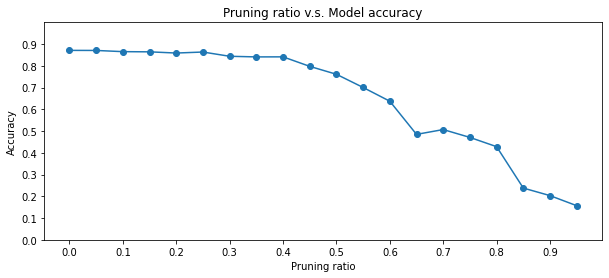

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,4))
plt.plot(ratios, np.array(accs),'o-')
xtic = np.arange(0.0, 1.0, 0.1)
ytic = np.arange(0.0, 1.0, 0.1)
plt.ylim(0,1)
plt.xticks(xtic)
plt.yticks(xtic)
plt.xlabel('Pruning ratio')
plt.ylabel('Accuracy')
plt.title('Pruning ratio v.s. Model accuracy')
plt.savefig('acc_ratio.png', dpi=200)